In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../..'))) # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_validation, probability_meta_validation
from src.python.networks import HierarchicalInvariantNetwork, ModelProbabilityNetwork
from src.python.models import HierarchicalNormalSimulator, MainSimulator
from src.python.losses import softmax_loss
from src.python.helpers import n_clust_obs_f_f, calibration_curve_with_ece, get_repeated_predictions, get_bootstrapped_predictions, get_preds_and_bfs
from src.python.visualization import perf_tester, plot_calibration_curve_repetition_uncertainty

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.optimizers import Adam
from functools import partial
from time import perf_counter
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer 

In [2]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created 
_ = plt.figure()
plt.rcParams['figure.facecolor'] = 'w'

<Figure size 432x288 with 0 Axes>

# Model formulation

$$
\begin{align}
x_n &\sim \mathcal{N}(\theta_l, \sigma^2) \text{ for } n=1,...,N \\
\theta_l &\sim \mathcal{N}(\mu, \tau^2) \text{ for } l=1,...,L\\
\sigma^2 &\sim Half-Normal(\sigma_s)\\
\mu &\sim \mathcal{N}(\mu_0, \tau_0)\\
\tau^2 &\sim Half-Normal(\sigma_t)\\
\end{align}
$$

$$
\begin{align}
&\text{Null Model }M_0 \text{: } \mu=0\\
&\text{Alternative Model }M_1 \text{: } \mu \text{ allowed to differ from 0} \\
\end{align}
$$

# Set up networks

In [3]:
summary_net = HierarchicalInvariantNetwork(summary_meta_validation)
probability_net = ModelProbabilityNetwork(probability_meta_validation)

amortizer = MultiModelAmortizer(probability_net, summary_net)

simulator = MainSimulator(HierarchicalNormalSimulator())

In [4]:
# Training steps
epochs=10 
iterations_per_epoch=1000

# Cosine decaying learning rate
initial_lr = 0.0005
decay_steps = epochs*iterations_per_epoch
alpha = 0
lr_schedule = CosineDecay(
    initial_lr, decay_steps, alpha=alpha
    )

# Checkpoint path for loading pretrained network and saving the final network
checkpoint_path = 'C:\\Users\\lasse\\Documents\\hierarchical_model_comparison_project\\checkpoints\\01_calibration_validation\\checkpoints_fixed'

trainer = ModelComparisonTrainer(
    network=amortizer, 
    generative_model=simulator, 
    loss=partial(softmax_loss),
    optimizer=partial(Adam, lr_schedule),
    checkpoint_path=checkpoint_path,
    skip_checks=True,
    )

Networks loaded from C:\Users\lasse\Documents\hierarchical_model_comparison_project\checkpoints\01_calibration_validation\checkpoints_fixed\ckpt-10


# Train & validate

In [5]:
training_time_start = perf_counter()
losses = trainer.train_online(epochs=epochs, iterations_per_epoch=iterations_per_epoch, batch_size=32, n_obs=n_clust_obs_f_f)
training_time_stop = perf_counter()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

ECE = 0.012


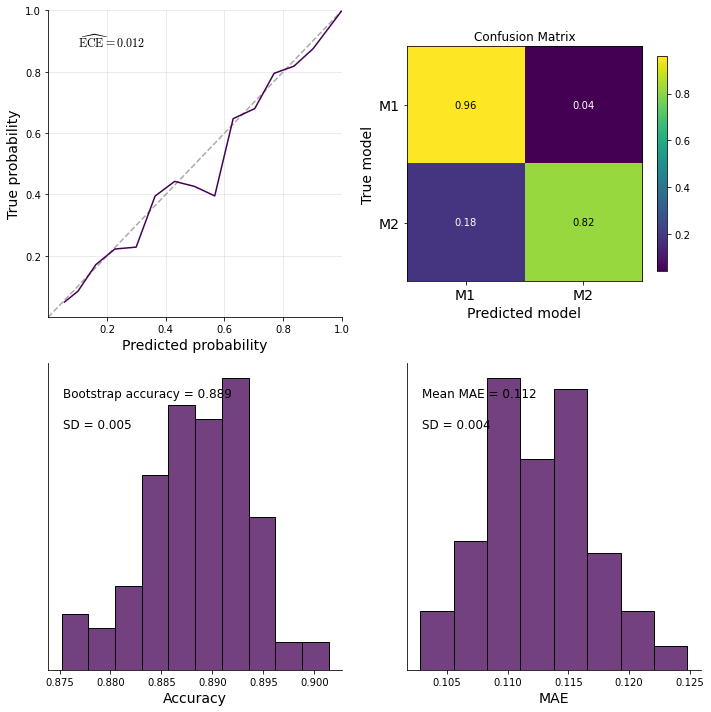

In [5]:
# Validation
n_val = 5000
m_val, _, x_val = simulator(n_val, n_clust_obs_f_f())
val_data = {'X' : x_val, 'm' : m_val}

perf_tester(probability_net, summary_net, val_data, n_cal_bins=15)

Median ECE = 0.01091362036541104


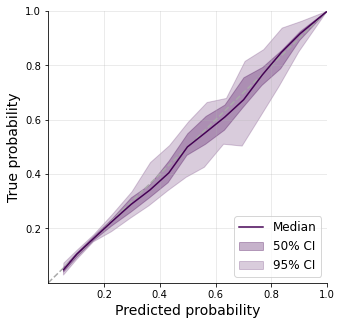

In [6]:
# Plot calibration with repetition uncertainty
n_repetitions = 25

fig, ax = plt.subplots(1, 1, figsize=(5,5))
m_true_r, m_soft_r = get_repeated_predictions(probability_net, summary_net, partial(simulator, batch_size=n_val, n_obs=n_clust_obs_f_f(50, 50)), 
                                          n_models=2, n_repetitions=n_repetitions)

plot_calibration_curve_repetition_uncertainty(m_true_r[:,:,1], m_soft_r[:,:,1], narrow_ci=[0.25, 0.75], wide_ci=[0.025, 0.975], n_bins=15, ax=ax, 
                                    xlabel=True, ylabel=True, title=None, show_ece=True, show_legend=True)

fig.savefig('calibration_fixed.pdf', dpi=300, bbox_inches='tight')

In [14]:
# Save training meta-information for bridge sampling comparison?
save_training_vars = False

if save_training_vars:
    folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', '01_calibration_validation', '01_fixed')

    np.save(os.path.join(folder, 'training_time_start'), training_time_start, allow_pickle=True)
    np.save(os.path.join(folder, 'training_time_stop'), training_time_stop, allow_pickle=True)
    np.save(os.path.join(folder, 'losses'), losses, allow_pickle=True)

# Calculate Bayes factors for bridge sampling comparison

In [2]:
# Import training meta-information? (if network was loaded from checkpoint)
import_training_vars = True

if import_training_vars:
    folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', '01_calibration_validation', '01_fixed')

    training_time_start = np.load(os.path.join(folder, 'training_time_start.npy'), allow_pickle=True)
    training_time_stop = np.load(os.path.join(folder, 'training_time_stop.npy'), allow_pickle=True)
    losses = np.load(os.path.join(folder, 'losses.npy'), allow_pickle=True).item()

In [9]:
# Import test data
val_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', '02_bridge_sampling_comparison', 'nested_models')
data_filename = "test_data.npy"
test_data = np.load(os.path.join(val_folder, data_filename), allow_pickle=True).item()

In [10]:
# Get NN predictions
comparison_results = get_preds_and_bfs(probability_net, summary_net, test_data, training_time_start, training_time_stop, losses)
comparison_results.head(5)

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time,final_epoch_loss
0,1,0,0.830225,0.169775,0,0.204492,745.100906,0.002514,0.287687
1,2,0,0.880637,0.119363,0,0.135542,745.100906,0.002514,0.287687
2,3,0,0.882400,0.117600,0,0.133273,745.100906,0.002514,0.287687
3,4,1,0.000001,0.999999,1,838859.800000,745.100906,0.002514,0.287687
4,5,0,0.883319,0.116681,0,0.132094,745.100906,0.002514,0.287687


In [12]:
# Export results
local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo
filename = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d_BF_NN_fixed')
comparison_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', '02_bridge_sampling_comparison', 'nested_models')

comparison_results.to_csv(os.path.join(comparison_folder, filename), index = False)